In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [26]:
def convolve2d(matrix, kernel, type='valid'):
    """
    isto kao cross_correlate, samo se kernel rotira 180
    """
    # Get the dimensions of the input matrix and kernel
    m, n = matrix.shape
    km, kn = kernel.shape

    if type == 'valid':
    
        # Calculate the dimensions of the output matrix
        output_dim_m = m - km + 1
        output_dim_n = n - kn + 1
        output = np.zeros((output_dim_m, output_dim_n))
        
        # Flip the kernel for convolution
        kernel_flipped = np.rot90(kernel, 2) # or kernel_flipped = np.flipud(np.fliplr(kernel))
        
        # Perform the convolution
        for i in range(output_dim_m):
            for j in range(output_dim_n):
                # Element-wise multiplication and summation
                region = matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel_flipped)
        
        return output
    
    elif type == 'full':

        output_dim_m = m + km - 1
        output_dim_n = n + kn - 1
        output = np.zeros((output_dim_m, output_dim_n))

        kernel_flipped = np.rot90(kernel, 2)

        padded_matrix = np.pad(matrix, ((km - 1, km - 1), (kn - 1, kn - 1)), mode='constant')

        for i in range(output_dim_m):
            for j in range(output_dim_n):
                region = padded_matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel_flipped)

        return output

def cross_correlate2d(matrix, kernel, type='valid'): 
    """
    OVO RADI

    dimenzija rezultata = dim_input - dim_kernel + 1
    Y = I - K + 1

    slidea kernel po regijama matrice velicine kernela, mnoze se elementi i zbrajaju

    valid - krece se u granicama matrice, od ruba do ruba, dimenzija je Y = I - K + 1

    full - izlazi van granica matrice, treba paddati matricu s nulama, Y = I + K - 1
    """
    # Get the dimensions of the input matrix and kernel
    m, n = matrix.shape
    km, kn = kernel.shape

    if type == 'valid':
        
        # Calculate the dimensions of the output matrix
        output_dim_m = m - km + 1
        output_dim_n = n - kn + 1
        output = np.zeros((output_dim_m, output_dim_n))
        
        # Perform the cross-correlation
        for i in range(output_dim_m):
            for j in range(output_dim_n):
                # Element-wise multiplication and summation
                region = matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel)
        
        return output
    
    elif type == 'full':
        
        # Calculate the dimensions of the output matrix
        output_dim_m = m + km - 1
        output_dim_n = n + kn - 1
        output = np.zeros((output_dim_m, output_dim_n))
        
        # Pad the input matrix with zeros
        padded_matrix = np.pad(matrix, ((km-1, km-1), (kn-1, kn-1)), mode='constant')

        # Perform the cross-correlation
        for i in range(output_dim_m):
            for j in range(output_dim_n):
                # Element-wise multiplication and summation
                region = padded_matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel)
        
        return output
        

# Cross Correlate

In [27]:
a = np.array([[1, 6, 2],
              [5, 3, 1],
              [7, 0 ,4]])

kernel = np.array([[1, 2],
                   [-1, 0]])

c = cross_correlate2d(a, kernel)
print(c)

c = signal.correlate2d(a, kernel, mode='valid')
print(c)

[[8. 7.]
 [4. 5.]]
[[8 7]
 [4 5]]


# Cross Correlate full

In [28]:
a = np.array([[1, 6, 2],
              [5, 3, 1],
              [7, 0 ,4]])

kernel = np.array([[1, 2],
                   [-1, 0]])

c = cross_correlate2d(a, kernel, type='full')
print(c)

c = signal.correlate2d(a, kernel)
print(c)

[[ 0. -1. -6. -2.]
 [ 2.  8.  7.  1.]
 [10.  4.  5. -3.]
 [14.  7.  8.  4.]]
[[ 0 -1 -6 -2]
 [ 2  8  7  1]
 [10  4  5 -3]
 [14  7  8  4]]


# Convolve

In [29]:
a = np.array([[1, 6, 2],
              [5, 3, 1],
              [7, 0 ,4]])

kernel = np.array([[1, 2],
                   [-1, 0]])

c = convolve2d(a, kernel)
print(c)

c = signal.convolve2d(a, kernel, mode='valid')
print(c)

[[ 7.  5.]
 [11.  3.]]
[[ 7  5]
 [11  3]]


# Convolve full

In [30]:
a = np.array([[1, 6, 2],
              [5, 3, 1],
              [7, 0 ,4]])

kernel = np.array([[1, 2],
                   [-1, 0]])

c = convolve2d(a, kernel, type='full')
print(c)

c = signal.convolve2d(a, kernel)
print(c)

[[ 1.  8. 14.  4.]
 [ 4.  7.  5.  2.]
 [ 2. 11.  3.  8.]
 [-7.  0. -4.  0.]]
[[ 1  8 14  4]
 [ 4  7  5  2]
 [ 2 11  3  8]
 [-7  0 -4  0]]


# Convolutional layer

In [31]:
from dlfs.base import Layer

class ConvolutionalLayer(Layer):

    def __init__(self, input_shape: tuple, output_depth: int, kernel_size: int) -> None:
        """
        Convolutional layer.

        Parameters
        ----------
        input_shape : tuple
            Dimension of a single sample processed by the layer. For images it's (depth, height, width).

        output_depth : int
            Depth of the output array.

        kernel_size : int
            Dimension of a single kernel, a square array of shape (kernel_size, kernel_size).
        """
        # Unpack the input_shape tuple
        input_depth, input_height, input_width = input_shape
        self.output_depth = output_depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (output_depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (output_depth, input_depth, kernel_size, kernel_size)
        # Initialize layer parameters
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass using the convolutional layer. Creates output attribute.

        Parameters
        ----------
        inputs : numpy.ndarray
            Input matrix.

        Returns
        -------
        None
        """
        # Number of samples, first dimension
        n_samples = inputs.shape[0]
        self.inputs = inputs

        # Output is 4D tensor of shape (n_samples, output_depth, height, width)
        self.output = np.zeros((n_samples, *self.output_shape))
        self.output += self.biases

        for i in range(self.output_depth):
            for j in range(self.input_depth):
                for k in range(n_samples):
                    self.output[k, i] += signal.correlate2d(self.inputs[k, j], self.kernels[i, j], mode="valid")
            
    def backward(self, delta: np.ndarray) -> None:
        """
        Backward pass using the convolutional layer. Creates gradient attributes with respect to kernels, biases and inputs.

        Parameters
        ----------
        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        Returns
        -------
        None
        """
        self.dkernels = np.zeros(self.kernels.shape)
        self.dbiases = np.zeros(self.biases.shape)
        self.dinputs = np.zeros(self.inputs.shape)
        n_samples = self.inputs.shape[0]

        for i in range(self.output_depth):
            for j in range(self.input_depth):
                for k in range(n_samples):
                    self.dkernels[i, j] += signal.correlate2d(self.inputs[k, j], delta[k, j], "valid")
                    self.dbiases[i] += delta[k, j]
                    self.dinputs[k, j] += signal.convolve2d(delta[k, j], self.kernels[i, j], "full")

# Reshape layer

In [32]:
class FlattenLayer(Layer):

    def __init__(self, input_shape, output_shape) -> None:
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, inputs):
        # converts [batch_size, channels, width, height] to [batch_size, channels * width * heigth]
        batch_size = inputs.shape[0]
        self.output = np.reshape(inputs, (batch_size, self.output_shape))

    def backward(self, delta):
        # converts [batch_size, channels * width * heigth] to [batch_size, channels, width, height]
        batch_size = delta.shape[0]
        self.dinputs = np.reshape(delta, (batch_size, *self.input_shape))

# Binary MNIST classification

In [33]:
from keras.datasets import mnist

def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    return x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

n_samples = x_train.shape[0]

In [34]:
from dlfs.layers import DenseLayer
from dlfs.activation import Sigmoid
from dlfs.loss import BCE_Loss
from dlfs.optimizers import Optimizer_SGD
from dlfs import Model

layers = [ConvolutionalLayer(input_shape=(1, 28, 28), output_depth=5, kernel_size=3),
          Sigmoid(),
          FlattenLayer(input_shape=(5, 26, 26), output_shape=(5 * 26 * 26)),
          DenseLayer(5 * 26 * 26, 100),
          Sigmoid(),
          DenseLayer(100, 1),
          Sigmoid()]

model = Model(layers=layers, loss_function=BCE_Loss(), optimizer=Optimizer_SGD())

model.train(x_train, y_train.reshape(-1, 1), print_every=20, iterations=150)

Loss: 0.6840571527929084
Loss: 0.6603718776157689
Loss: 0.11957035705954916
Loss: 0.05776641402876996
Loss: 0.03792050095473096
Loss: 0.028145839738918158
Loss: 0.02229200212834975
Loss: 0.018366728998340666


In [35]:
y_pred = model.predict(x_test)
print(f'acc: {np.mean(np.round(y_pred) == y_test.reshape(-1, 1))}')

acc: 0.99


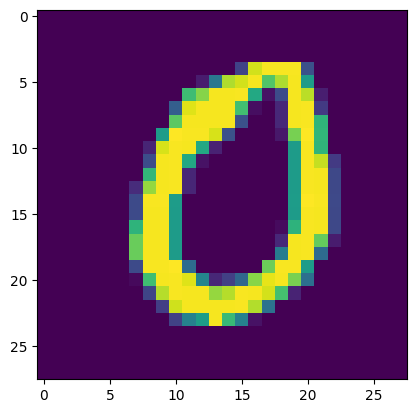

Label: [0.]


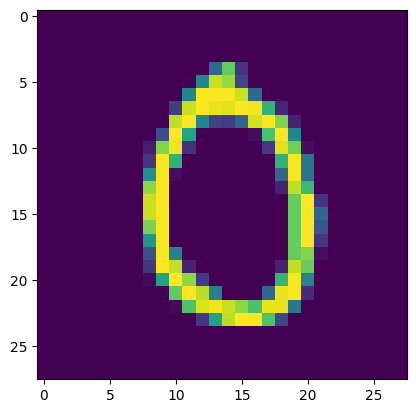

Label: [0.]


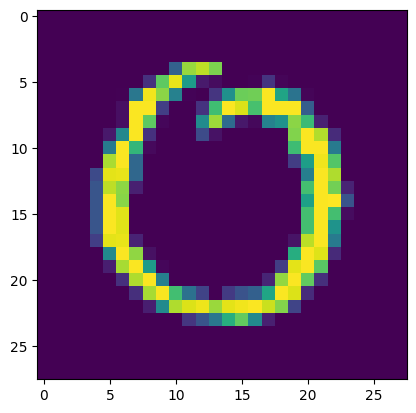

Label: [0.]


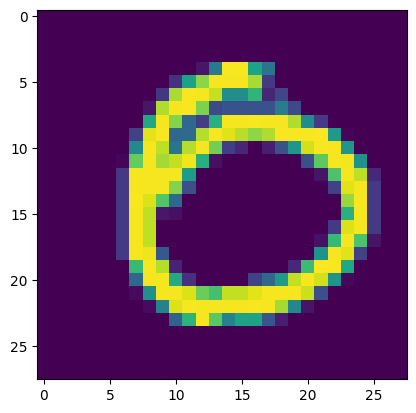

Label: [0.]


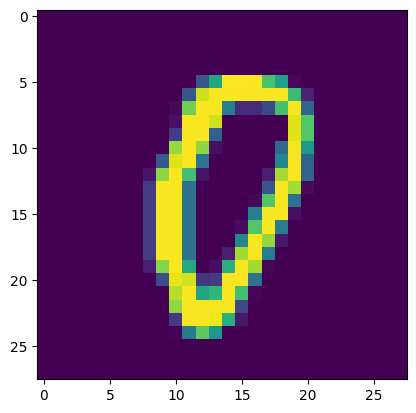

Label: [0.]


In [36]:
for x in x_test[:5]:
    img = x.reshape(28, 28)
    x = x.reshape(1, *x.shape)
    y_pred = model.predict(x)
    plt.imshow(img)
    plt.show()
    print(f'Label: {np.round(y_pred[0])}')

# MNIST classification

In [37]:
def preprocess_whole_mnist(x):
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    return x

def one_hot_encode(y):
    categories = np.unique(y)
    encoded_y = np.zeros((len(y), len(categories)))

    for idx, label in enumerate(y):
        to_encode_idx = np.argwhere(categories == label)
        encoded_y[idx, to_encode_idx] = 1

    return encoded_y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess_whole_mnist(x_train[:1000])
x_test = preprocess_whole_mnist(x_test[:1000])

y_train = one_hot_encode(y_train[:1000])
y_test = one_hot_encode(y_test[:1000])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 10)
(1000, 10)


In [38]:
class Loss_CCE:

    def calculate(self, y_pred, y_true):
        samples = range(len(y_pred))
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[samples, y_true]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        return (-np.sum(np.log(correct_confidences)))

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if(len(y_true.shape)) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples   

class Activation_Softmax:

    def forward(self, inputs):
        self.inputs = inputs
        exp = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp / np.sum(exp, axis=1, keepdims=True) 

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues) 

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            single_output = single_output.reshape(-1, 1)

            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues) 

In [39]:
layers = [ConvolutionalLayer(input_shape=(1, 28, 28), output_depth=5, kernel_size=3),
          Sigmoid(),
          FlattenLayer((5, 26, 26), (5 * 26 * 26)),
          DenseLayer(5 * 26 * 26, 100),
          Sigmoid(),
          DenseLayer(100, 10),
          Activation_Softmax()]

model = Model(layers=layers, loss_function=Loss_CCE(), optimizer=Optimizer_SGD(learning_rate=3e-2))

model.train(x_train, y_train, print_every=10, iterations=50)

Loss: 2623.128825236671
Loss: 2315.594454702281
Loss: 2267.899372522127
Loss: 2244.1334768816832
Loss: 2223.084606087994


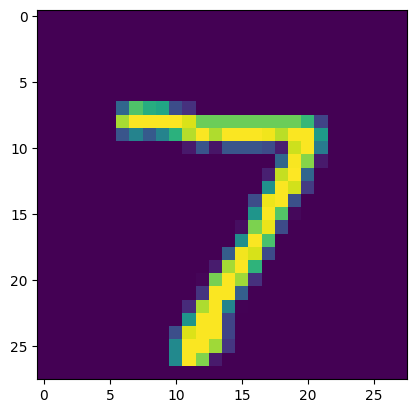

Label: 7


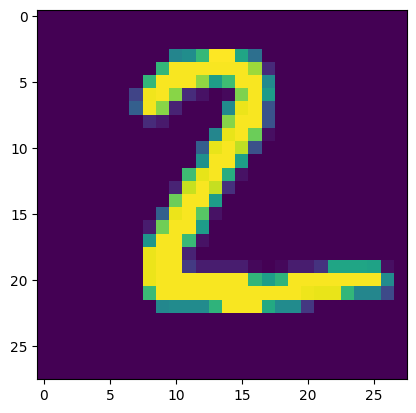

Label: 1


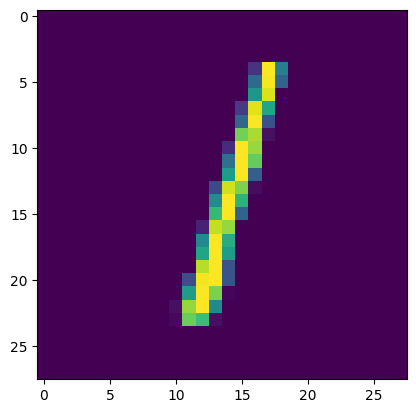

Label: 1


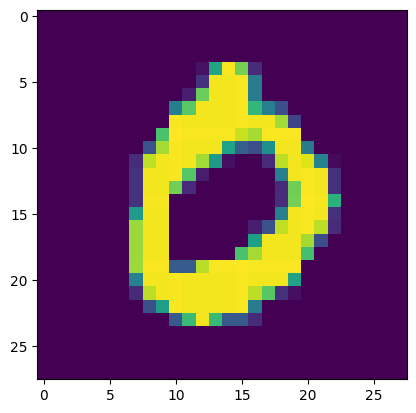

Label: 4


In [40]:
for x in x_test[:4]:
    img = x.reshape(28, 28)
    x = x.reshape(1, *x.shape)
    y_pred = model.predict(x)
    plt.imshow(img)
    plt.show()
    print(f'Label: {np.argmax(y_pred)}')